# 1. 데이터 불러오기

In [17]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [18]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


# 2. train,validation 비율 설정

In [19]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


# 3. 데이터 확인
정상이미지와 폐렴이미지를 구분해야 하는데
파일경로에 힌트가 있다.

In [20]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0618-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person399_virus_793.jpeg


정상이미지와 폐렴이미지 개수 확인

In [21]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


# 4. 데이터생성

tf.data 인스턴스로 변환

In [22]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


라벨데이터 생성   
경로에 맞는 이미지 및 라벨 검출

In [23]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [24]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

#AUTOTUNE으로 빠른 데이터 처리
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

데이터의 사이즈 및 라벨 확인

In [25]:
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False


test data 생성

In [26]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [27]:
# dataset 최적화
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 5. 데이터 시각화

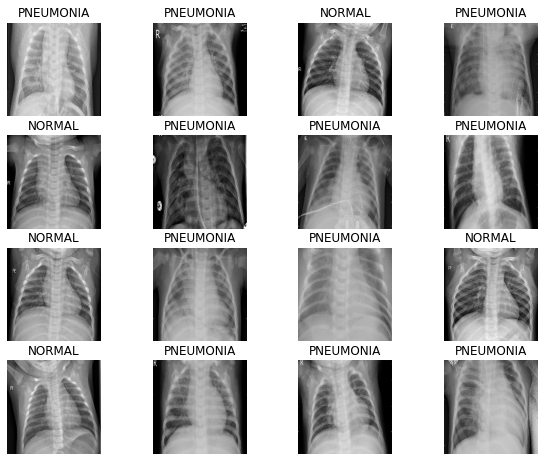

In [28]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 6. CNN 모델링

In [29]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 7. 데이터 imbalance 처리

In [30]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


# 8. 모델 학습

In [31]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [32]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 106s 252ms/step - loss: 0.5604 - accuracy: 0.7054 - precision: 0.9162 - recall: 0.6635 - val_loss: 0.7079 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 64s 244ms/step - loss: 0.2547 - accuracy: 0.8945 - precision: 0.9715 - recall: 0.8837 - val_loss: 1.1319 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 64s 247ms/step - loss: 0.2149 - accuracy: 0.9099 - precision: 0.9771 - recall: 0.9012 - val_loss: 0.7451 - val_accuracy: 0.7385 - val_precision: 0.7380 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 65s 250ms/step - loss: 0.1838 - accuracy: 0.9348 - precision: 0.9786 - recall: 0.9315 - val_loss: 0.0893 - val_accuracy: 0.9644 - val_precision: 0.9789 - val_recall: 0.9725
Epoch 5/25
261/261 [==============================] - 66s 255ms/step - loss: 0.1602 - accur

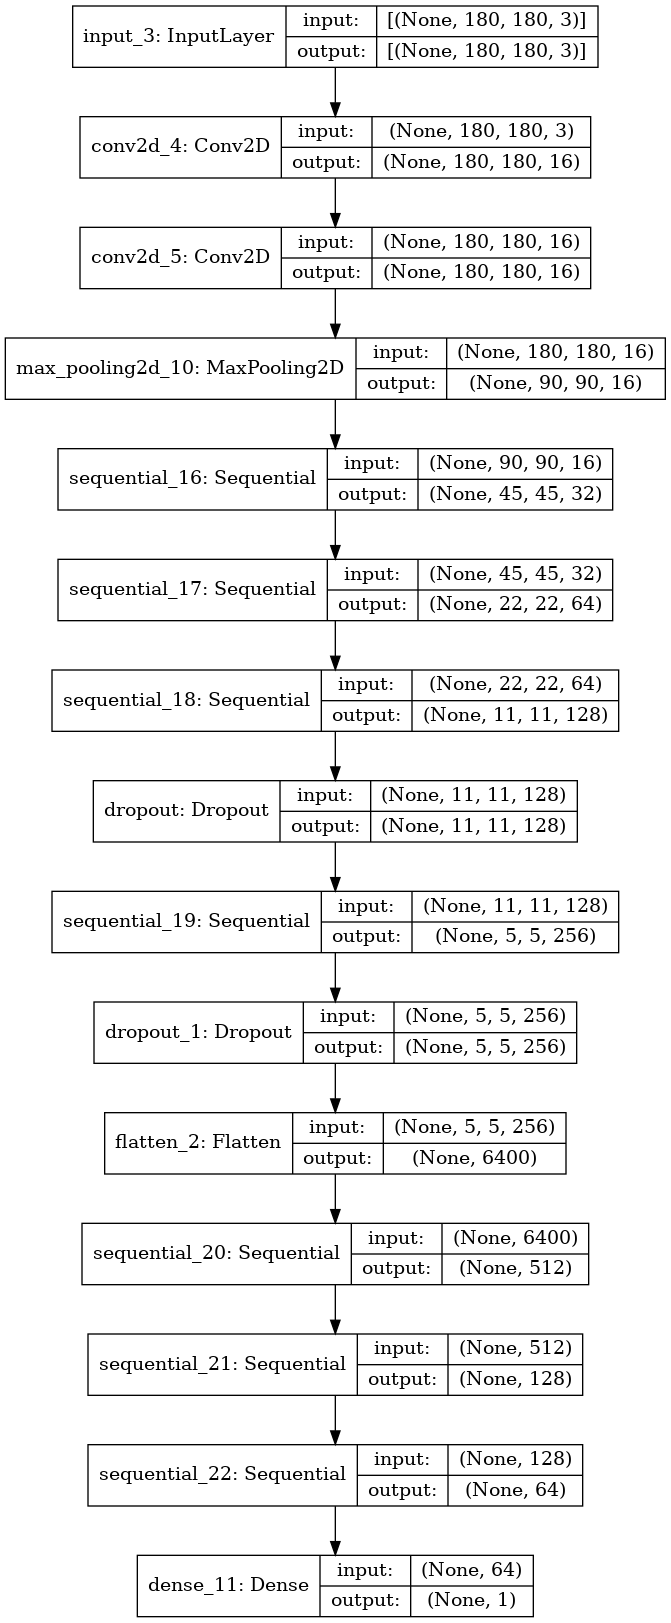

In [35]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# 9. 학습결과 확인

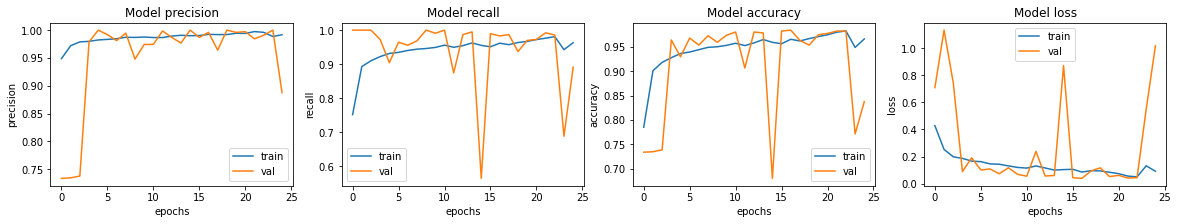

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 10. 학습평가

In [34]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 7s 158ms/step - loss: 3.3949 - accuracy: 0.7131 - precision: 0.7212 - recall: 0.8821
Loss: 3.3949005603790283,
Accuracy: 0.7131410241127014,
Precision: 0.7211740016937256,
Recall: 0.8820512890815735


# 11. Accuracy향상을 위한 노력

In [48]:
def improvement(BATCH_SIZE,EPOCHS,reverse):
    
    train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
    test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
    TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
    test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE)
    
    def augment(image,label):
        image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
        return image,label

    def prepare_for_training(ds, shuffle_buffer_size=1000):
        # augment 적용 부분이 배치처리 함수에 추가되었습니다.
        if reverse == True:
            ds = ds.map(
                    augment,       # augment 함수 적용
                    num_parallel_calls=2
                )
            
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.repeat()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

    train_ds = prepare_for_training(train_ds)
    val_ds = prepare_for_training(val_ds)


    def conv_block(filters):
        block = tf.keras.Sequential([
            tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
            tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D()
        ])

        return block

    def dense_block(units):
        block = tf.keras.Sequential([
            tf.keras.layers.Dense(units, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dropout(dropout_rate)
        ])

        return block

    def build_model():
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

            tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
            tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
            tf.keras.layers.MaxPool2D(),

            conv_block(32),
            conv_block(64),

            conv_block(128),
            #tf.keras.layers.Dropout(0.2),

            conv_block(256),
            #tf.keras.layers.Dropout(0.2),

            tf.keras.layers.Flatten(),
            dense_block(512),
            dense_block(128),
            dense_block(64),

            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        return model


    weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
    weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
    print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))


    with tf.device('/GPU:0'):
        model = build_model()

        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]

        model.compile(
            optimizer= 'adam',
            loss='binary_crossentropy',
            metrics=METRICS
            
        )

        history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            class_weight=class_weight,
        )
    return history,model

In [49]:
improvement(BATCH_SIZE=8,
            EPOCHS=12,
            reverse=True
           )

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67
Epoch 1/12
523/523 [==============================] - 79s 129ms/step - loss: 0.3736 - accuracy: 0.8338 - precision: 0.9536 - recall: 0.8153 - val_loss: 0.6955 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/12
523/523 [==============================] - 66s 126ms/step - loss: 0.2490 - accuracy: 0.8926 - precision: 0.9677 - recall: 0.8850 - val_loss: 0.1178 - val_accuracy: 0.9587 - val_precision: 0.9533 - val_recall: 0.9921
Epoch 3/12
523/523 [==============================] - 67s 128ms/step - loss: 0.2154 - accuracy: 0.9114 - precision: 0.9751 - recall: 0.9048 - val_loss: 0.1029 - val_accuracy: 0.9654 - val_precision: 0.9840 - val_recall: 0.9685
Epoch 4/12
523/523 [==============================] - 67s 127ms/step - loss: 0.1612 - accuracy: 0.9314 - precision: 0.9821 - recall: 0.9248 - val_loss: 0.3440 - val_accuracy: 0.8519 - val_precision: 0.9795 - val_recall: 0.8150
Epoch 5/12
523/523 [=====================

(<tensorflow.python.keras.callbacks.History at 0x7f10e448d190>,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7f10cac128d0>)

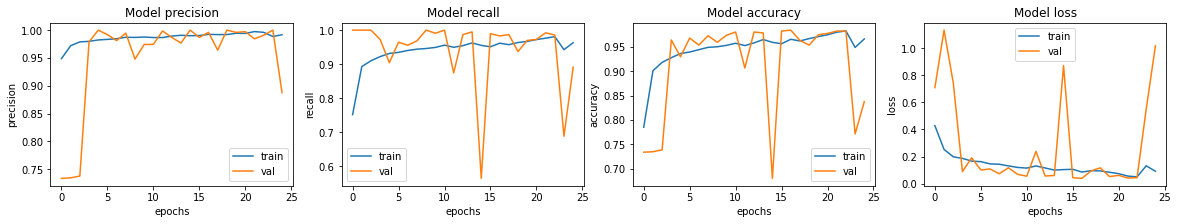

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [51]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 7s 159ms/step - loss: 0.7964 - accuracy: 0.8061 - precision: 0.7844 - recall: 0.9513
Loss: 0.7964118719100952,
Accuracy: 0.8060897588729858,
Precision: 0.7843551635742188,
Recall: 0.9512820243835449
